In [1]:
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import loguniform
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix,
    PrecisionRecallDisplay, roc_curve, roc_auc_score
)
from sklearn.model_selection import (
    cross_validate, RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder
)
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

If data is not downloaded yet it can be downloaded using the following command.

In [37]:
!python ../src/download_data.py --url="https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv" --out_file="../data/raw/heart_failure_clinical_records_dataset.csv"

In [32]:
# Load data
df = pd.read_csv('../data/raw/heart_failure_clinical_records_dataset.csv')
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_file = '../data/processed/Heart_Failure_Data_train.csv'
test_file = '../data/processedHeart_Failure_Data_test.csv'
train_df.to_csv(train_file, index=False)
test_df.to_csv(test_file, index=False)

In [5]:
#Reading the data
train_df = pd.read_csv("../data/processed/Heart_Failure_Data_train.csv")
test_df = pd.read_csv("../data/processed/Heart_Failure_Data_test.csv")

In [6]:
train_df['DEATH_EVENT'].value_counts()

0    168
1     71
Name: DEATH_EVENT, dtype: int64

* The dataset is imbalanced as we have lesser number of examples of DEATH_EVENT.
* To tackle this problem we can use the class weight in our training model so that the results will be less biased.

##### Let's split the data to train our model :

In [7]:
# Data splitting
X_train = train_df.drop("DEATH_EVENT", axis=1)
y_train = train_df['DEATH_EVENT']
X_test = test_df.drop("DEATH_EVENT", axis=1)
y_test = test_df['DEATH_EVENT']

* We will categorize the features in the dataset for prerocessing.
* Even though all the values are numeric, 'sex', 'diabetes', 'high_blood_pressure', 'anaemia' - these features have yes/no or binary values.Thus we'll apply OneHotEncoder on binary features.
* To bring all the numeric values in same scale , we apply StandardScalar on numeric features.
* Our target is the feature - 'DEATH_EVENT'

In [38]:
# Seperate the features for preprocessing
numeric_features = ['age','creatinine_phosphokinase','ejection_fraction',
                    'platelets','serum_creatinine','serum_sodium','time']

binary_feats = ['sex', 'diabetes', 'high_blood_pressure', 'anaemia']
target= "DEATH_EVENT"

In [39]:
#define a column transformer
col_trans = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_feats),

)

##### We are using 'accuracy', 'precision', 'recall', 'f1' as our metrics to evaluate the model

In [40]:
# Define the metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']


#### Here we are using two classifiers for the initial performance calculation : 
1. KNeighborsClassifier
2. RandomForestClassifier

In [41]:
#Performance calculation
results = {}
pipe_knn = make_pipeline(
    col_trans,
    KNeighborsClassifier(n_neighbors=3)
)
results['KNeighborsClassifier'] = pd.DataFrame(cross_validate(pipe_knn, X_train,
                                        y_train, scoring=scoring)).mean()

pipe_rf = make_pipeline(
    col_trans,
    RandomForestClassifier(random_state=123)
)
results['RandomForestClassifier'] = pd.DataFrame(cross_validate(pipe_rf, X_train,
                                                y_train, scoring=scoring)).mean()

In [42]:
pd.DataFrame(results)

,KNeighborsClassifier,RandomForestClassifier
fit_time,0.012466,0.150226
score_time,0.013371,0.019212
test_accuracy,0.753103,0.844858
test_precision,0.634524,0.775291
test_recall,0.350476,0.688571
test_f1,0.445406,0.724418


* We can observe that we arre getting better scores with RandomForestClassifier. To analyze further let's perform hyperparameter optimization on RandomForestClassifier.

In [43]:
param_dist = {
    "randomforestclassifier__max_depth": np.arange(10, 20, 2),
    "randomforestclassifier__class_weight": [None, "balanced"],
    "randomforestclassifier__n_estimators": [10, 20, 40, 100, 200, 400, 800],
}
rand_search_rf = RandomizedSearchCV(pipe_rf, param_dist, n_iter=20, 
                                    random_state=952, scoring=scoring, refit="precision")

rand_search_rf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatinine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium',
                                                                                'time']),
                                                                

In [44]:
# Test the fitted model 
y_train_predict = rand_search_rf.predict(X_train)
y_train_predict

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
      dtype=int64)

In [45]:
# Predict on test data
y_predict = rand_search_rf.predict(X_test)
y_predict

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [46]:
# Table of Metrics for positive class for train and test set
performance_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_train_predict), accuracy_score(y_test, y_predict)],
        "Precision": [precision_score(y_train, y_train_predict), precision_score(y_test, y_predict)],
        "Recall": [recall_score(y_train, y_train_predict), recall_score(y_test, y_predict)],
        "F1 Score": [f1_score(y_train, y_train_predict), f1_score(y_test, y_predict)]
    },
    index=["Training Data Set", "Test Data Set"])
performance_df

,Accuracy,Precision,Recall,F1 Score
Training Data Set,1.000000,1.00,1.00,1.000000
Test Data Set,0.816667,0.85,0.68,0.755556


##### Since we are interested in predicting the death of person, 'DEATH_EVENT' is our positive class

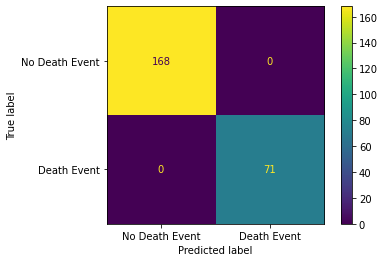

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

pipe_rf.fit(X_train, y_train)
cm = ConfusionMatrixDisplay.from_estimator(
    pipe_rf, X_train, y_train, values_format="d", display_labels=["No Death Event", "Death Event"]
)



##### We can see from the above confusion matrix that we got rid of 'False Positives' and 'False Negatives'. Now let's visualize the confusion matrix of test data.

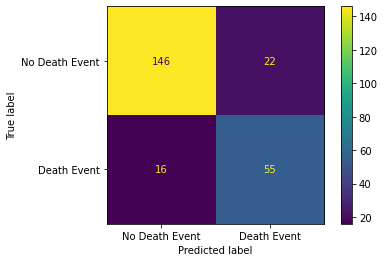

In [48]:
# Confusion Matrix for the test set

pipe_rf.fit(X_test, y_test)
cm = ConfusionMatrixDisplay.from_estimator(
    pipe_rf, X_train, y_train, values_format="d", display_labels=["No Death Event","Death Event"]
)

##### - From the above confusion matrix for the test data we can observe that With the RandomForestClassifier we got 22 'False Positives'. This means our model predicted 18 cases as death but in reality no death event has occured for those cases.
##### - Similarly we got 16 'False Negatives'. This means our model predicted 18 cases as no death but in reality death event has occured for those cases.


### Test the model :

In [49]:
print(
    classification_report(
        y_test, rand_search_rf.predict(X_test), target_names=["No Death Event","Death Event"]
    )
)

                precision    recall  f1-score   support

No Death Event       0.80      0.91      0.85        35
   Death Event       0.85      0.68      0.76        25

      accuracy                           0.82        60
     macro avg       0.82      0.80      0.80        60
  weighted avg       0.82      0.82      0.81        60



In [50]:
# Table of Metrics for train set
PR_curve_df = pd.DataFrame(precision_recall_curve(y_train, rand_search_rf.predict_proba(X_train)[:,1],), index=["precision","recall","threshold"]).T
PR_curve_df['F1 Score'] =  2 * (PR_curve_df['precision'] * PR_curve_df['recall'])/(PR_curve_df['precision'] + PR_curve_df['recall'])
PR_curve_df

,precision,recall,threshold,F1 Score
0,1.0,1.000000,0.585,1.000000
1,1.0,0.985915,0.625,0.992908
2,1.0,0.971831,0.635,0.985714
3,1.0,0.957746,0.640,0.978417
4,1.0,0.929577,0.645,0.963504
5,1.0,0.915493,0.665,0.955882
6,1.0,0.901408,0.700,0.948148
7,1.0,0.873239,0.715,0.932331
8,1.0,0.859155,0.720,0.924242
9,1.0,0.845070,0.725,0.916031


In [51]:
ap_forest = average_precision_score(y_test, pipe_rf.predict_proba(X_test)[:, 1])
print("Average precision for the  Random Forest Classifier:")
print(ap_forest)

Average precision for the  Random Forest Classifier:
1.0


In [52]:
# Threshold to get best F1 score
maximum_f1_df = PR_curve_df.iloc[PR_curve_df["F1 Score"].idxmax()].to_frame().T
best_thres = maximum_f1_df['threshold'].iloc[0]
maximum_f1_df

,precision,recall,threshold,F1 Score
0,1.0,1.0,0.585,1.0


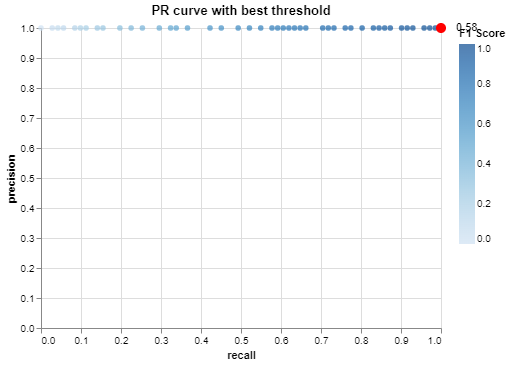

In [53]:
# PR curve with best threshold

PR_curve = alt.Chart(PR_curve_df).mark_circle().encode(
    x="recall",
    y="precision",
    color="F1 Score"
)
max_f1_point = alt.Chart(maximum_f1_df, 
                         title = 'PR curve with best threshold',).mark_circle(
    color="red", size=100, opacity=1).encode(
    x="recall",
    y="precision"
)

text = max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("threshold", format = ".2f"))

PR_curve_plot = PR_curve + max_f1_point + text
PR_curve_plot

In [54]:
# Evaluate Model with test data set with best_thres
y_pred_train_thres = rand_search_rf.predict_proba(X_train)[:, 1] > best_thres
y_pred_thres = rand_search_rf.predict_proba(X_test)[:, 1] > best_thres

In [55]:
# Table of Metrics for positive class with best_thres
model_perf_thres_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_pred_train_thres), accuracy_score(y_test, y_pred_thres)],
        "Precision": [precision_score(y_train, y_pred_train_thres), precision_score(y_test, y_pred_thres)],
        "Recall": [recall_score(y_train, y_pred_train_thres), recall_score(y_test, y_pred_thres)],
        "F1 Score": [f1_score(y_train, y_pred_train_thres), f1_score(y_test, y_pred_thres)]
    },
    index=["Training data with best threshold", "Test Data with best threshold"])

In [56]:
best_threshold_df = pd.concat([performance_df, model_perf_thres_df])
best_threshold_df

,Accuracy,Precision,Recall,F1 Score
Training Data Set,1.000000,1.000000,1.000000,1.000000
Test Data Set,0.816667,0.850000,0.680000,0.755556
Training data with best threshold,0.995816,1.000000,0.985915,0.992908
Test Data with best threshold,0.783333,0.928571,0.520000,0.666667


#### ROC Curve

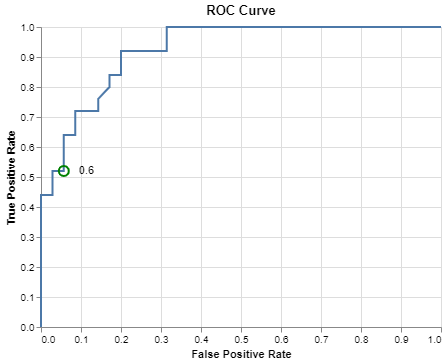

In [57]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rand_search_rf.predict_proba(X_test)[:, 1])

roc_df = pd.DataFrame()
roc_df['fpr'] = false_positive_rate
roc_df['tpr'] = true_positive_rate
roc_df['thresholds'] = thresholds

pt_roc_index = (roc_df['thresholds'] - best_thres).abs().argmin()

roc_curves = alt.Chart(roc_df, title = "ROC Curve").mark_line().encode(
        alt.X('fpr', title="False Positive Rate"),
        alt.Y('tpr', title="True Positive Rate"))

roc_max_f1_point = alt.Chart(pd.DataFrame(roc_df.iloc[pt_roc_index]).T, 
                         ).mark_point(
    color="green", size=100, opacity=1).encode(
    x="fpr",
    y="tpr"
)

roc_text = roc_max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("thresholds:Q", format = ".1f"))

roc_curve_plot = roc_curves + roc_max_f1_point + roc_text
roc_curve_plot

#### ROC_AUC and Average Precision score

In [58]:
ap_forest = average_precision_score(y_test, rand_search_rf.predict_proba(X_test)[:, 1])
roc_forest = roc_auc_score(y_test, rand_search_rf.predict_proba(X_test)[:, 1])

test_model_perf_df = pd.DataFrame({
    "Accuracy" : model_perf_thres_df.loc["Test Data with best threshold"]["Accuracy"],
    "Precision" : model_perf_thres_df.loc["Test Data with best threshold"]["Precision"],
    "Recall" : model_perf_thres_df.loc["Test Data with best threshold"]["Recall"],
    "F1 Score" : model_perf_thres_df.loc["Test Data with best threshold"]["F1 Score"],
    "Average Precision Score" : ap_forest,
    "AUC Score" : roc_forest},
    index = ["Test Data Metrics"]).T
test_model_perf_df

,Test Data Metrics
Accuracy,0.783333
Precision,0.928571
Recall,0.520000
F1 Score,0.666667
Average Precision Score,0.898228
AUC Score,0.924000


#### Feature importance

In [59]:
importances = pipe_rf["randomforestclassifier"].feature_importances_
importances

array([0.12400402, 0.07521965, 0.09284984, 0.07536459, 0.18984165,
       0.07912204, 0.30969314, 0.01076293, 0.01789027, 0.01458661,
       0.01066527])

<AxesSubplot:>

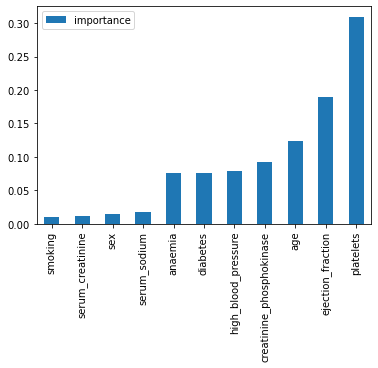

In [60]:
%matplotlib inline
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, pipe_rf["randomforestclassifier"].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(by='importance').plot(kind='bar', rot=90)

* The above plot shows the distribution of important features given by the RandomForestClassifier. With the model that we trained it seems platelets count affect more in the death event followed by the ejection_fraction.
* Furthermore if we can reduce the checkup/follow-up time it will icrease the chances of survival of the person.